## import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

import torch
import torchvision
import torchvision.transforms as transforms

import torch.utils.data as tud
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import optuna
import skorch

import sklearn.datasets as skl_datasets
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
import sklearn.manifold as manifold
import sklearn.decomposition as decomposition

import skorch.callbacks as skorch_callbacks
import skorch.dataset as skorch_datasets

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", mpl.__version__)
print("sklearn:", sklearn.__version__)

print("torch version", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("skoarch version:", skorch.__version__)
print("torch cuda version:", torch.cuda_version)
print("cuda is available:", torch.cuda.is_available())
print("cuda device count:", torch.cuda.device_count())
print("cuda device name:", torch.cuda.get_device_name())
print("capability:", torch.cuda.get_device_capability())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

numpy: 1.23.1
pandas: 1.4.4
matplotlib: 3.5.2
sklearn: 1.1.2
torch version 1.12.1
torchvision version: 0.13.1
skoarch version: 0.11.0
torch cuda version: 11.3
cuda is available: True
cuda device count: 1
cuda device name: NVIDIA GeForce GTX 1650
capability: (7, 5)


device(type='cuda')

## 動作確認

参考： [【skorch】Pytorchをscikit-learnのような使い心地にするライブラリ｜はやぶさの技術ノート](https://cpp-learning.com/skorch/)

### 模擬データの作成

In [2]:
# make dataset
x, y = skl_datasets.make_classification(
    n_samples=300,
    n_classes=2,
    n_features=5,
    random_state=0)

# split dataset (train:test = 7:3)
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=42)

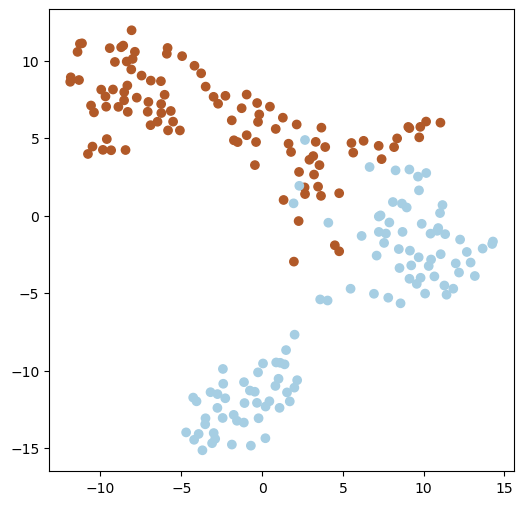

In [3]:
def plot_tsne(x, y, figsize=(6, 6), colormap=plt.cm.Paired):
    '''Visualize features with t-SNE'''
    plt.figure(figsize=figsize)
    tsne = manifold.TSNE(init='random', learning_rate='auto')
    x_embedded = tsne.fit_transform(x)
    plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=y, cmap=colormap)
    plt.show()

def plot_pca(x, y, figsize=(6, 6), colormap=plt.cm.Paired):
    '''Visualize features with PCA'''
    plt.figure(figsize=figsize)
    pca = decomposition.PCA(n_components=2)
    x_embedded = pca.fit_transform(x)
    plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=y, cmap=colormap)
    plt.show()

# Visualize features
plot_tsne(x_train, y_train)
#plot_pca(x_train, y_train)

### ベース

概要
```py
model = skorch.NeuralNetClassifier(
    Net,                             # 中身のモデル
    lr=0.01,                         # optimizer の学習率
    criterion=nn.CrossEntropyLoss,   # 損失関数
    optimizer=optim.SGD,             # 最適化アルゴリズム
    optimizer__momentum=0.9,         # optimizer の(lr 以外の)パラメータ
    max_epochs=100,                  # epoch 数
    batch_size=128,                  # batch_size の指定
    iterator_train__shuffle=True,    # trainをシャッフルする(train Dataloader のパラメータ)
    train_split=skorch_datasets.ValidSplit( # train と valid の分割関数
        cv=5,                            # cross_validation の分割
        stratified=False),               # 階層分類を行うかどうか(マルチクラスの場合)
    callbacks=[                      # epochに前後で実行される関数
        skorch_callbacks.Checkpoint(),
        skorch_callbacks.EarlyStopping()],
    warm_start=True,                 # fitで学習を引き継いで開始する
    verbose=1,                       # ログ出力
    device="cpu",                    # デバイス指定
)
```

In [4]:
class Net(nn.Module):
    def __init__(self, input_size=5, output_class=2, width=100):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(input_size, width)
        self.layer2 = nn.Linear(width, width, bias=True)
        self.layer3 = nn.Linear(width, width, bias=True)
        self.layer4 = nn.Linear(width, output_class, bias=True)

    def forward(self, x):
        x = x.float()
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        #x = F.softmax(x, dim=-1)
        return x

In [5]:
# set param(make trainer)
model = skorch.NeuralNetClassifier(
    Net,
    lr=0.01,
    criterion=nn.CrossEntropyLoss, # 損失関数
    optimizer=optim.SGD, # 最適化アルゴリズム
    optimizer__momentum=0.9, # optimizer の(lr 以外の)パラメータ
    max_epochs=100,
    #batch_size=128, # batch_size の指定
    iterator_train__shuffle=True,
    #train_split=skorch_datasets.ValidSplit(cv=5, stratified=False),
    callbacks=[
        skorch_callbacks.Checkpoint(),
        skorch_callbacks.EarlyStopping()],
    warm_start=True,
    #verbose=1,
    #device="cpu",
)

# learn
model.fit(x_train, y_train.astype(np.int64))

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.6900       0.5000        0.6891     +  0.0140
      2        0.6871       0.5000        0.6831     +  0.0100
      3        0.6817       0.5000        0.6748     +  0.0070
      4        0.6742       0.6190        0.6649     +  0.0090
      5        0.6652       0.6905        0.6537     +  0.0080
      6        0.6553       0.8095        0.6415     +  0.0100
      7        0.6440       0.9286        0.6282     +  0.0090
      8        0.6321       0.9524        0.6135     +  0.0080
      9        0.6186       0.9524        0.5972     +  0.0080
     10        0.6036       0.9762        0.5789     +  0.0080
     11        0.5871       0.9762        0.5582     +  0.0090
     12        0.5681       0.9762        0.5349     +  0.0080
     13        0.5468       0.9762        0.5088     +  0.0130
     14        0.5226       0.9762        0.4801     + 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (layer1): Linear(in_features=5, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=100, bias=True)
    (layer3): Linear(in_features=100, out_features=100, bias=True)
    (layer4): Linear(in_features=100, out_features=2, bias=True)
  ),
)

学習曲線

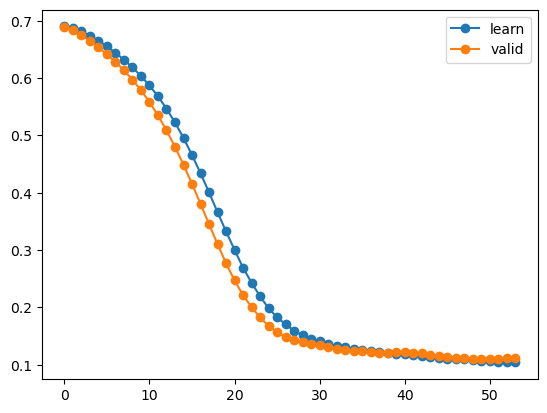

In [6]:
plt.plot(
    range(len(model.history)),
    [dic["train_loss"] for dic in model.history],
    "o-", label="learn"
)
plt.plot(
    range(len(model.history)),
    [dic["valid_loss"] for dic in model.history],
    "o-", label="valid"
)
plt.legend()

指標

In [7]:
# print precision, recall, f1-score, support
print("train loss: %.4f" % metrics.log_loss(y_train, model.predict_proba(x_train)))
print(metrics.classification_report(y_train, model.predict(x_train)))

# print precision, recall, f1-score, support
print("test accuracy: %.4f" % metrics.log_loss(y_test, model.predict_proba(x_test)))
print(metrics.classification_report(y_test, model.predict(x_test)))

train loss: 0.1060
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       106
           1       0.95      0.98      0.97       104

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210

test accuracy: 0.1453
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        43
           1       0.92      0.96      0.94        47

    accuracy                           0.93        90
   macro avg       0.93      0.93      0.93        90
weighted avg       0.93      0.93      0.93        90



### CUDAを使用

In [8]:
# set param(make trainer)
model = skorch.NeuralNetClassifier(
    Net,
    lr=0.01,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    max_epochs=100,
    #batch_size=128,
    iterator_train__shuffle=True,
    #train_split=skorch_datasets.ValidSplit(cv=5, stratified=False),
    callbacks=[
        skorch_callbacks.Checkpoint(),
        skorch_callbacks.EarlyStopping()],
    warm_start=True,
    #verbose=1,
    device="cuda"
)

# learn
model.fit(x_train, y_train.astype(np.int64))

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.6849       0.8810        0.6825     +  3.5060
      2        0.6816       0.9762        0.6759     +  0.0210
      3        0.6754       0.9762        0.6665     +  0.0180
      4        0.6663       0.9524        0.6547     +  0.0180
      5        0.6555       0.9524        0.6408     +  0.0170
      6        0.6430       0.9524        0.6251     +  0.0170
      7        0.6285       0.9524        0.6076     +  0.0180
      8        0.6123       0.9524        0.5878     +  0.0190
      9        0.5939       0.9524        0.5654     +  0.0180
     10        0.5726       0.9524        0.5400     +  0.0170
     11        0.5494       0.9524        0.5114     +  0.0180
     12        0.5230       0.9524        0.4799     +  0.0190
     13        0.4930       0.9524        0.4456     +  0.0190
     14        0.4604       0.9524        0.4088     + 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (layer1): Linear(in_features=5, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=100, bias=True)
    (layer3): Linear(in_features=100, out_features=100, bias=True)
    (layer4): Linear(in_features=100, out_features=2, bias=True)
  ),
)

### モデルにパラメータを指定

渡すのはクラスでもインスタンスでもよい

In [9]:
# set param(make trainer)
model = skorch.NeuralNetClassifier(
    Net(width=200),
    lr=0.01,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    max_epochs=100,
    iterator_train__shuffle=True,
    callbacks=[
        skorch_callbacks.Checkpoint(),
        skorch_callbacks.EarlyStopping()],
    warm_start=True,
)

# learn
model.fit(x_train, y_train.astype(np.int64))

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.7125       0.3095        0.7028     +  0.0440
      2        0.7048       0.5714        0.6863     +  0.0380
      3        0.6898       0.9048        0.6649     +  0.0210
      4        0.6709       0.9286        0.6401     +  0.0190
      5        0.6493       0.9286        0.6137     +  0.0270
      6        0.6266       0.9524        0.5860     +  0.0250
      7        0.6019       0.9524        0.5569     +  0.0330
      8        0.5747       0.9524        0.5251     +  0.0210
      9        0.5464       0.9524        0.4901     +  0.0160
     10        0.5133       0.9524        0.4527     +  0.0170
     11        0.4779       0.9524        0.4127     +  0.0190
     12        0.4394       0.9524        0.3710     +  0.0180
     13        0.3996       0.9524        0.3291     +  0.0190
     14        0.3577       0.9524        0.2885     + 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (layer1): Linear(in_features=5, out_features=200, bias=True)
    (layer2): Linear(in_features=200, out_features=200, bias=True)
    (layer3): Linear(in_features=200, out_features=200, bias=True)
    (layer4): Linear(in_features=200, out_features=2, bias=True)
  ),
)

### batch_sizeを変えた場合

In [10]:
# set param(make trainer)
model = skorch.NeuralNetClassifier(
    Net,
    lr=0.01,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    max_epochs=100,
    batch_size=16,
    iterator_train__shuffle=True,
    callbacks=[
        skorch_callbacks.Checkpoint(),
        skorch_callbacks.EarlyStopping()],
    warm_start=True,
)

# learn
model.fit(x_train, y_train.astype(np.int64))

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.6695       0.9048        0.6200     +  0.1020
      2        0.5691       0.9286        0.4616     +  0.0870
      3        0.3971       0.9524        0.2531     +  0.0360
      4        0.2193       0.9762        0.1617     +  0.0710
      5        0.1517       0.9762        0.1373     +  0.0490
      6        0.1302       0.9762        0.1343     +  0.0960
      7        0.1248       0.9762        0.1330     +  0.0410
      8        0.1191       0.9762        0.1252     +  0.0350
      9        0.1151       0.9762        0.1205     +  0.0310
     10        0.1108       0.9762        0.1155     +  0.0290
     11        0.1074       0.9762        0.1104     +  0.0280
     12        0.1119       0.9762        0.1087     +  0.0340
     13        0.1029       0.9524        0.1050     +  0.0300
     14        0.1156       0.9762        0.1045     + 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (layer1): Linear(in_features=5, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=100, bias=True)
    (layer3): Linear(in_features=100, out_features=100, bias=True)
    (layer4): Linear(in_features=100, out_features=2, bias=True)
  ),
)

学習曲線

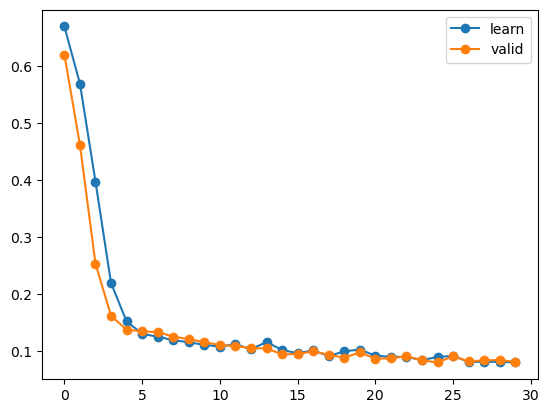

In [11]:
plt.plot(
    range(len(model.history)),
    [dic["train_loss"] for dic in model.history],
    "o-", label="learn"
)
plt.plot(
    range(len(model.history)),
    [dic["valid_loss"] for dic in model.history],
    "o-", label="valid"
)
plt.legend()

lossがより急激に下がるようになるので lr は小さくすべき．

### optimizerを変える

In [12]:
# set param(make trainer)
model = skorch.NeuralNetClassifier(
    Net,
    lr=0.01,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    optimizer__betas=(0.9, 0.999),
    max_epochs=100,
    #batch_size=128,
    iterator_train__shuffle=True,
    #train_split=skorch_datasets.ValidSplit(cv=5, stratified=False),
    callbacks=[
        skorch_callbacks.Checkpoint(),
        skorch_callbacks.EarlyStopping()],
    warm_start=True,
    #verbose=1,
    #device="cpu",
)

# learn
model.fit(x_train, y_train.astype(np.int64))

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.6595       0.9524        0.3210     +  0.0280
      2        0.3002       0.9286        0.1751     +  0.0160
      3        0.1674       0.9524        0.1850        0.0150
      4        0.2155       0.9762        0.1392     +  0.0160
      5        0.1217       0.9286        0.1741        0.0170
      6        0.1448       0.9286        0.1315     +  0.0160
      7        0.1069       0.9762        0.0887     +  0.0160
      8        0.1067       0.9762        0.0824     +  0.0160
      9        0.1131       0.9762        0.0781     +  0.0160
     10        0.0997       0.9762        0.0801        0.0160
     11        0.0901       0.9762        0.0904        0.0150
     12        0.0860       0.9762        0.1021        0.0150
     13        0.0837       0.9762        0.1083        0.0150
Stopping since valid_loss has not improved in the last 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (layer1): Linear(in_features=5, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=100, bias=True)
    (layer3): Linear(in_features=100, out_features=100, bias=True)
    (layer4): Linear(in_features=100, out_features=2, bias=True)
  ),
)

### Cross Validation

標準ではcvを指定しても1つしか使われずhold-outになるのでcross validationにする場合はvalidationを切るように指定する必要がある

In [13]:
def cross_validation(
        model, x, y, k_fold=5, random_state=42, verbosity=1, device=None):
    x = x.astype(np.float32)
    y = y.astype(np.int64)
    kf = model_selection.KFold(k_fold, shuffle=True, random_state=random_state)
    train_losses = []
    valid_losses = []
    for _fold, (train_index, valid_index) in enumerate(kf.split(range(len(x)))):
        x_train = x[train_index]
        y_train = y[train_index]
        x_valid = x[valid_index]
        y_valid = y[valid_index]
        
        model_params = model.get_params()
        model_params["callbacks"] = [
            skorch_callbacks.Checkpoint(monitor=lambda Net: Net.history[-1, 'train_loss_best']),
            skorch_callbacks.EarlyStopping(monitor='train_loss')]
        model_params["train_split"]=None
        model = model.__class__(**model_params)
        
        model.fit(x_train, y_train)
        valid_loss = model.get_loss(
            torch.from_numpy(model.predict_proba(x_valid)).float(),
            y_valid)
        train_losses += [model.history[-1]["train_loss"]]
        valid_losses += [valid_loss]
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)
    if verbosity>0:
        print(f"total; train loss: {train_losses.mean():.4f}, "
              f"valid loss: {valid_losses.mean():.4f}")
    return train_losses, valid_losses

In [14]:
model = skorch.NeuralNetClassifier(
    Net,
    lr=0.01,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    max_epochs=100,
    iterator_train__shuffle=True,
    warm_start=True,
)

cross_validation(model, x_train, y_train)

  epoch    train_loss    cp     dur
-------  ------------  ----  ------
      1        0.6881     +  0.0110
      2        0.6852     +  0.0130
      3        0.6797     +  0.0120
      4        0.6725     +  0.0120
      5        0.6635     +  0.0120
      6        0.6531     +  0.0120
      7        0.6413     +  0.0110
      8        0.6282     +  0.0110
      9        0.6133     +  0.0170
     10        0.5967     +  0.0270
     11        0.5772     +  0.0240
     12        0.5554     +  0.0220
     13        0.5298     +  0.0110
     14        0.5022     +  0.0100
     15        0.4708     +  0.0130
     16        0.4368     +  0.0120
     17        0.4010     +  0.0120
     18        0.3645     +  0.0120
     19        0.3282     +  0.0110
     20        0.2920     +  0.0200
     21        0.2598     +  0.0260
     22        0.2303     +  0.0290
     23        0.2057     +  0.0150
     24        0.1877     +  0.0110
     25        0.1704     +  0.0160
     26        0.1582     + 

     83        0.0798     +  0.0200
     84        0.0791     +  0.0110
     85        0.0785     +  0.0130
     86        0.0786        0.0120
     87        0.0788        0.0120
     88        0.0788        0.0110
     89        0.0779     +  0.0120
     90        0.0775     +  0.0130
     91        0.0772     +  0.0110
     92        0.0769     +  0.0240
     93        0.0763     +  0.0110
     94        0.0756     +  0.0130
     95        0.0750     +  0.0250
     96        0.0752        0.0300
     97        0.0754        0.0210
     98        0.0748     +  0.0360
     99        0.0747     +  0.0100
    100        0.0736     +  0.0170
  epoch    train_loss    cp     dur
-------  ------------  ----  ------
      1        0.7016     +  0.0120
      2        0.6969     +  0.0110
      3        0.6875     +  0.0110
      4        0.6752     +  0.0120
      5        0.6603     +  0.0120
      6        0.6435     +  0.0100
      7        0.6264     +  0.0120
      8        0.6076     + 

     65        0.1277     +  0.0070
     66        0.1267     +  0.0080
     67        0.1251     +  0.0070
     68        0.1242     +  0.0080
     69        0.1232     +  0.0070
     70        0.1222     +  0.0080
     71        0.1214     +  0.0070
     72        0.1205     +  0.0090
     73        0.1206        0.0070
     74        0.1201     +  0.0070
     75        0.1196     +  0.0070
     76        0.1186     +  0.0070
     77        0.1178     +  0.0080
     78        0.1166     +  0.0070
     79        0.1161     +  0.0070
     80        0.1155     +  0.0080
     81        0.1154     +  0.0090
     82        0.1147     +  0.0080
     83        0.1139     +  0.0080
     84        0.1130     +  0.0070
     85        0.1132        0.0080
     86        0.1132        0.0080
     87        0.1132        0.0080
     88        0.1126     +  0.0080
     89        0.1117     +  0.0100
     90        0.1110     +  0.0090
     91        0.1103     +  0.0070
     92        0.1095     + 

(array([0.0584679 , 0.07356743, 0.07659779, 0.10602395, 0.08371185]),
 array([0.3803905 , 0.3725293 , 0.37917766, 0.32391506, 0.36464313],
       dtype=float32))

## ハイパーパラメータ最適化

In [15]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    momentum = trial.suggest_float("momentum", 1e-5, 1, log=True)
    
    model = skorch.NeuralNetClassifier(
        Net,
        lr=learning_rate,
        criterion=nn.CrossEntropyLoss,
        optimizer=optim.SGD,
        optimizer__momentum=momentum,
        max_epochs=100,
        iterator_train__shuffle=True,
        warm_start=True,
        verbose=0, device="cuda"
    )
    model.fit(x_train, y_train.astype(np.int64))
    valid_loss = model.history[-1]["valid_loss"]
    if not np.isfinite(valid_loss):
        print("value not finite:", trial.params, valid_loss)
    return valid_loss

In [16]:
study = optuna.create_study()
study.optimize(objective, n_trials=10)

[I 2022-09-27 20:46:18,520] A new study created in memory with name: no-name-61f25758-ce21-4b9d-bf2a-b51a4022d1b1
[I 2022-09-27 20:46:19,923] Trial 0 finished with value: 0.3912082016468048 and parameters: {'learning_rate': 0.008116756059365078, 'momentum': 0.04626575605413582}. Best is trial 0 with value: 0.3912082016468048.
[I 2022-09-27 20:46:20,977] Trial 1 finished with value: 0.09097222238779068 and parameters: {'learning_rate': 0.8914268824460613, 'momentum': 0.0005961369044422091}. Best is trial 1 with value: 0.09097222238779068.
[I 2022-09-27 20:46:22,027] Trial 2 finished with value: 0.6150468587875366 and parameters: {'learning_rate': 0.0017325743958675516, 'momentum': 0.13555458938613746}. Best is trial 1 with value: 0.09097222238779068.
[I 2022-09-27 20:46:23,053] Trial 3 finished with value: 0.6582260727882385 and parameters: {'learning_rate': 2.255783525467674e-05, 'momentum': 0.014234956757842422}. Best is trial 1 with value: 0.09097222238779068.
[I 2022-09-27 20:46:24,

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\605004869.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_slice(study, params=[param])


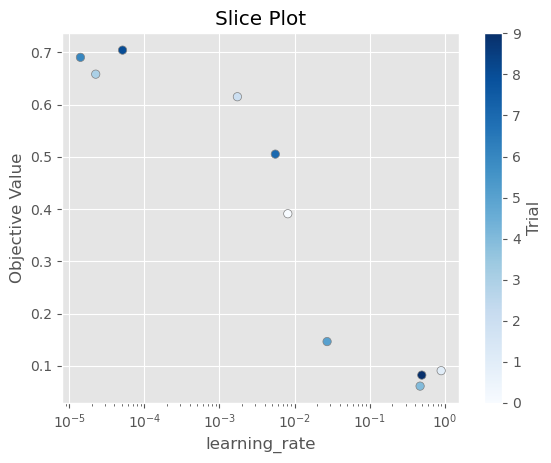

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\605004869.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_slice(study, params=[param])


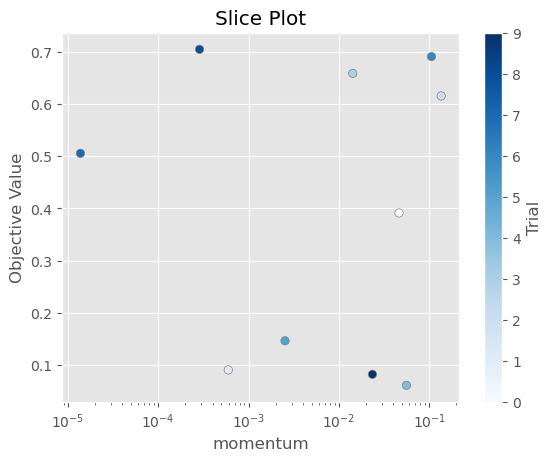

In [17]:
for param in study.best_params.keys():
    ax = optuna.visualization.matplotlib.plot_slice(study, params=[param])
    plt.show()

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\4290272586.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_contour(study)
[W 2022-09-27 20:46:30,921] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


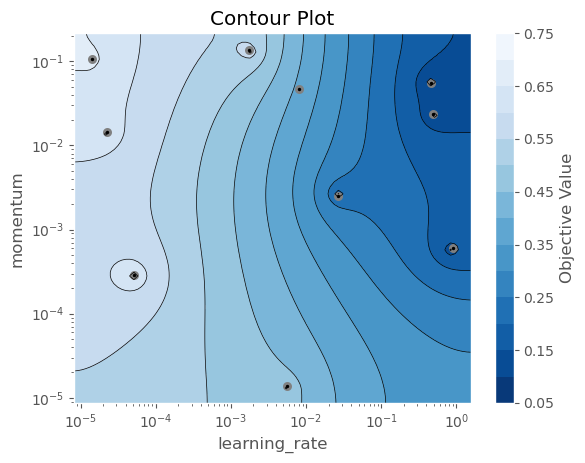

In [18]:
ax = optuna.visualization.matplotlib.plot_contour(study)
plt.show()

In [19]:
study.optimize(objective, n_trials=40, n_jobs=4)

[I 2022-09-27 20:46:35,238] Trial 13 finished with value: 0.0831957757472992 and parameters: {'learning_rate': 0.08733724451000931, 'momentum': 0.8654012412050623}. Best is trial 4 with value: 0.06140589714050293.
[I 2022-09-27 20:46:35,575] Trial 12 finished with value: 0.08271151036024094 and parameters: {'learning_rate': 0.08189119328814051, 'momentum': 0.6215113693946713}. Best is trial 4 with value: 0.06140589714050293.
[I 2022-09-27 20:46:35,921] Trial 11 finished with value: 0.060849957168102264 and parameters: {'learning_rate': 0.04366991900127558, 'momentum': 0.7603291589541314}. Best is trial 11 with value: 0.060849957168102264.
[I 2022-09-27 20:46:36,268] Trial 10 finished with value: 0.07888780534267426 and parameters: {'learning_rate': 0.10116383548891542, 'momentum': 0.6306065735979953}. Best is trial 11 with value: 0.060849957168102264.
[I 2022-09-27 20:46:38,858] Trial 14 finished with value: 0.07517234236001968 and parameters: {'learning_rate': 0.9976175993621372, 'mom

[I 2022-09-27 20:47:07,355] Trial 46 finished with value: 0.06784216314554214 and parameters: {'learning_rate': 0.5291981071078979, 'momentum': 0.0032673980849134603}. Best is trial 45 with value: 0.04504057392477989.
[I 2022-09-27 20:47:08,592] Trial 47 finished with value: 0.05427176505327225 and parameters: {'learning_rate': 0.5002579358904438, 'momentum': 0.0031637271520023507}. Best is trial 45 with value: 0.04504057392477989.
[I 2022-09-27 20:47:08,778] Trial 48 finished with value: 0.062315646559000015 and parameters: {'learning_rate': 0.5657307808132768, 'momentum': 0.013099194802195475}. Best is trial 45 with value: 0.04504057392477989.
[I 2022-09-27 20:47:09,083] Trial 49 finished with value: 0.0627005472779274 and parameters: {'learning_rate': 0.6458814405900006, 'momentum': 0.0030145649469699265}. Best is trial 45 with value: 0.04504057392477989.


C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\605004869.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_slice(study, params=[param])


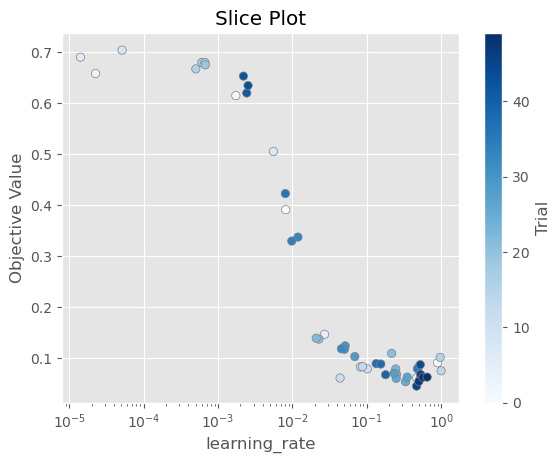

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\605004869.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_slice(study, params=[param])


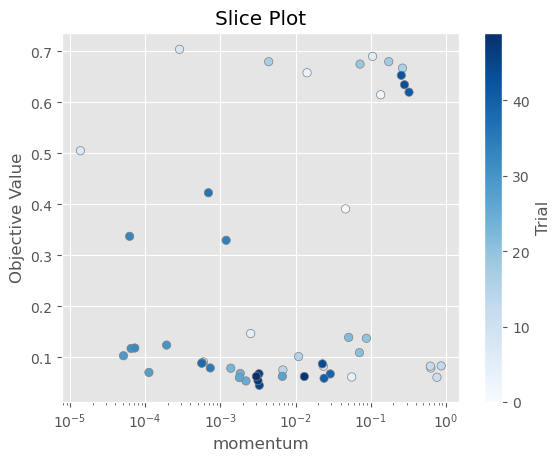

In [20]:
for param in study.best_params.keys():
    ax = optuna.visualization.matplotlib.plot_slice(study, params=[param])
    plt.show()

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\4290272586.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_contour(study)
[W 2022-09-27 20:47:10,084] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


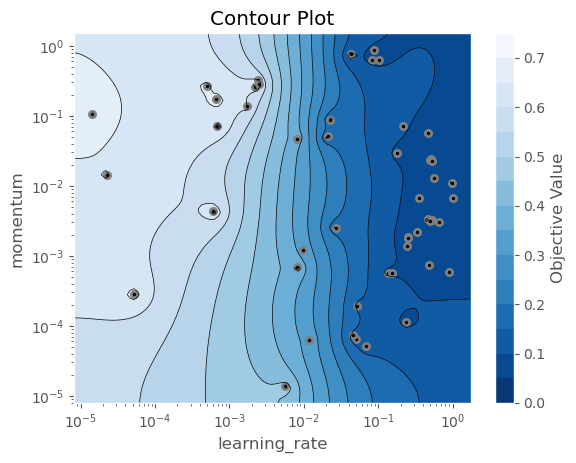

In [21]:
ax = optuna.visualization.matplotlib.plot_contour(study)
plt.show()

In [22]:
import pickle
with open("study.bin", "wb") as file:
    pickle.dump(study, file)

少し範囲を絞って再実行

In [23]:
def objective2(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1, log=True)
    momentum = trial.suggest_float("momentum", 1e-5, 1, log=True)
    
    model = skorch.NeuralNetClassifier(
        Net,
        lr=learning_rate,
        criterion=nn.CrossEntropyLoss,
        optimizer=optim.SGD,
        optimizer__momentum=momentum,
        max_epochs=100,
        iterator_train__shuffle=True,
        warm_start=True,
        verbose=0, device="cuda"
    )
    model.fit(x_train, y_train.astype(np.int64))
    valid_loss = model.history[-1]["valid_loss"]
    if not np.isfinite(valid_loss):
        print("value not finite:", trial.params, valid_loss)
    return valid_loss

In [24]:
study2 = optuna.create_study()
study2.optimize(objective2, n_trials=1)

# レンジ内のみデータを継承
dists = study2.trials[0].distributions
for trial in study.get_trials():
    params = trial.params
    if all((dists[key].low <= params[key] <= dists[key].high) for key in params.keys())\
            and trial.value is not None:
        study2.add_trial(
            optuna.trial.create_trial(
                params=params,
                distributions=dists,
                value=trial.value))

len(study2.trials)

[I 2022-09-27 20:47:10,914] A new study created in memory with name: no-name-a609e598-4f35-4514-aea5-d2976f4fafb7
[I 2022-09-27 20:47:12,067] Trial 0 finished with value: 0.05839543044567108 and parameters: {'learning_rate': 0.44737613167998475, 'momentum': 0.07755279385293828}. Best is trial 0 with value: 0.05839543044567108.


44

In [25]:
study2.optimize(objective2, n_trials=100-len(study2.trials), n_jobs=4)

[I 2022-09-27 20:47:15,201] Trial 45 finished with value: 0.07070725411176682 and parameters: {'learning_rate': 0.34180865388188825, 'momentum': 0.0058326643957003895}. Best is trial 39 with value: 0.04504057392477989.
[I 2022-09-27 20:47:15,445] Trial 47 finished with value: 0.07535281032323837 and parameters: {'learning_rate': 0.3352251126379539, 'momentum': 0.007228629953749161}. Best is trial 39 with value: 0.04504057392477989.
[I 2022-09-27 20:47:15,620] Trial 46 finished with value: 0.06018596515059471 and parameters: {'learning_rate': 0.34787905855315804, 'momentum': 0.005308908408843026}. Best is trial 39 with value: 0.04504057392477989.
[I 2022-09-27 20:47:15,942] Trial 44 finished with value: 0.07562670111656189 and parameters: {'learning_rate': 0.36996701307450747, 'momentum': 0.005689336825484589}. Best is trial 39 with value: 0.04504057392477989.
[I 2022-09-27 20:47:18,985] Trial 48 finished with value: 0.06746123731136322 and parameters: {'learning_rate': 0.33474158031201

[I 2022-09-27 20:47:45,200] Trial 80 finished with value: 0.0536951906979084 and parameters: {'learning_rate': 0.4292246217585149, 'momentum': 0.0024706322686523507}. Best is trial 39 with value: 0.04504057392477989.
[I 2022-09-27 20:47:46,208] Trial 81 finished with value: 0.07011045515537262 and parameters: {'learning_rate': 0.43307135006095954, 'momentum': 0.0026358136006520375}. Best is trial 39 with value: 0.04504057392477989.
[I 2022-09-27 20:47:46,821] Trial 82 finished with value: 0.6787626147270203 and parameters: {'learning_rate': 0.0011235146746734134, 'momentum': 0.0026314651198503626}. Best is trial 39 with value: 0.04504057392477989.
[I 2022-09-27 20:47:47,082] Trial 83 finished with value: 0.08314873278141022 and parameters: {'learning_rate': 0.16707582880393554, 'momentum': 0.002488271880782358}. Best is trial 39 with value: 0.04504057392477989.
[I 2022-09-27 20:47:48,330] Trial 84 finished with value: 0.07856116443872452 and parameters: {'learning_rate': 0.813153857714

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\2234045468.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_slice(study2, params=[param])


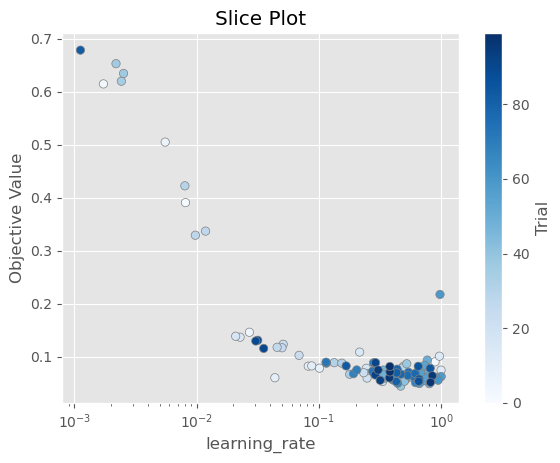

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\2234045468.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_slice(study2, params=[param])


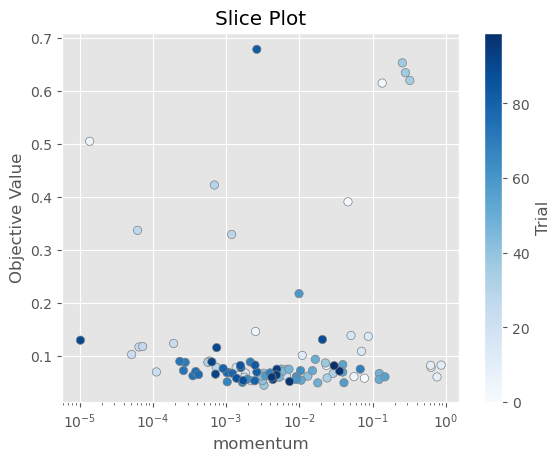

In [26]:
for param in study2.best_params.keys():
    ax = optuna.visualization.matplotlib.plot_slice(study2, params=[param])
    plt.show()

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\216952225.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_contour(study2, target=lambda trial:min(0.2, trial.value))
[W 2022-09-27 20:48:00,402] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
C:\Users\Sakishita\anaconda3\envs\torch\lib\site-packages\optuna\visualization\_utils.py:69: UserWarning: `target` is specified, but `target_name` is the default value, 'Objective Value'.
  warnings.warn(


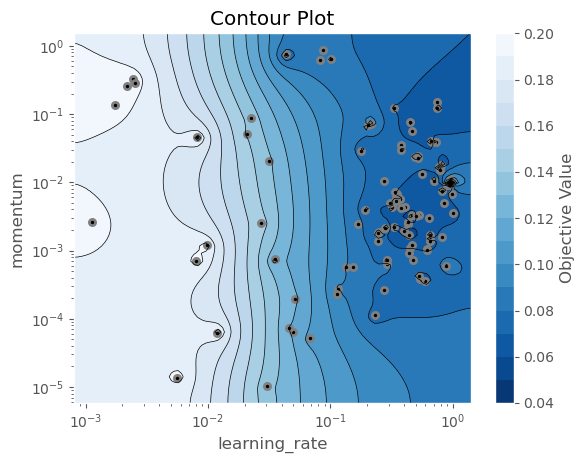

In [27]:
ax = optuna.visualization.matplotlib.plot_contour(study2, target=lambda trial:min(0.2, trial.value))
plt.show()

In [28]:
import pickle
with open("study2.bin", "wb") as file:
    pickle.dump(study2, file)

Adamでもやってみる  

In [30]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    comp_beta1 = trial.suggest_float("comp_beta1", 1e-5, 1, log=True)
    comp_beta2 = trial.suggest_float("comp_beta2", 1e-5, 1, log=True)
    
    model = skorch.NeuralNetClassifier(
        Net,
        lr=learning_rate,
        criterion=nn.CrossEntropyLoss,
        optimizer=optim.Adam,
        optimizer__betas=(1-comp_beta1, 1-comp_beta1),
        max_epochs=100,
        iterator_train__shuffle=True,
        warm_start=True,
        verbose=0, device="cuda"
    )
    model.fit(x_train, y_train.astype(np.int64))
    valid_loss = model.history[-1]["valid_loss"]
    if not np.isfinite(valid_loss):
        print("value not finite:", trial.params, valid_loss)
    return valid_loss

In [31]:
study = optuna.create_study()
study.optimize(objective, n_trials=10, n_jobs=4)

[I 2022-09-27 20:48:01,226] A new study created in memory with name: no-name-b5af1fe6-76e5-4837-9c4a-bdbd39edcb49
[I 2022-09-27 20:48:05,301] Trial 0 finished with value: 0.575959324836731 and parameters: {'learning_rate': 2.2895818692284545e-05, 'comp_beta1': 0.00014487316009437025, 'comp_beta2': 0.002109221901493177}. Best is trial 0 with value: 0.575959324836731.
[I 2022-09-27 20:48:05,696] Trial 3 finished with value: 0.5701109766960144 and parameters: {'learning_rate': 3.2459816646628964e-05, 'comp_beta1': 0.02775962241254305, 'comp_beta2': 0.026328437531294657}. Best is trial 3 with value: 0.5701109766960144.
[I 2022-09-27 20:48:05,784] Trial 1 finished with value: 0.4741004407405853 and parameters: {'learning_rate': 0.012640098623983893, 'comp_beta1': 0.009826570627997746, 'comp_beta2': 1.9612294143963863e-05}. Best is trial 1 with value: 0.4741004407405853.
[I 2022-09-27 20:48:07,899] Trial 2 finished with value: 0.18053333461284637 and parameters: {'learning_rate': 0.010104665

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\580515141.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_slice(study, params=[param])


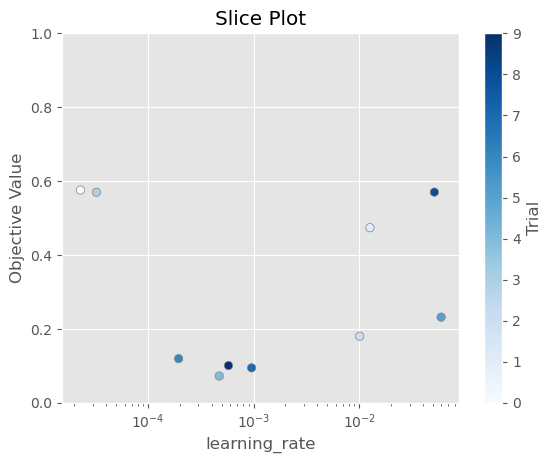

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\580515141.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_slice(study, params=[param])


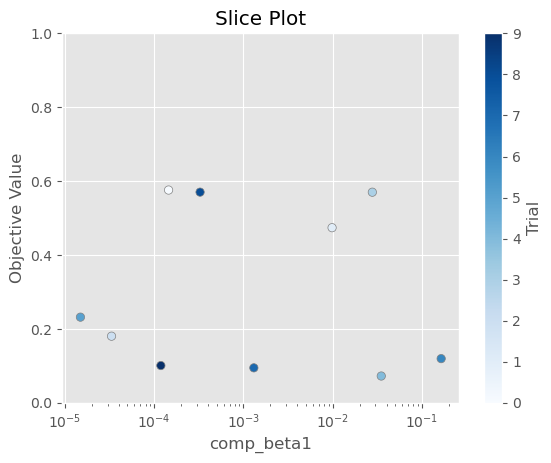

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\580515141.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_slice(study, params=[param])


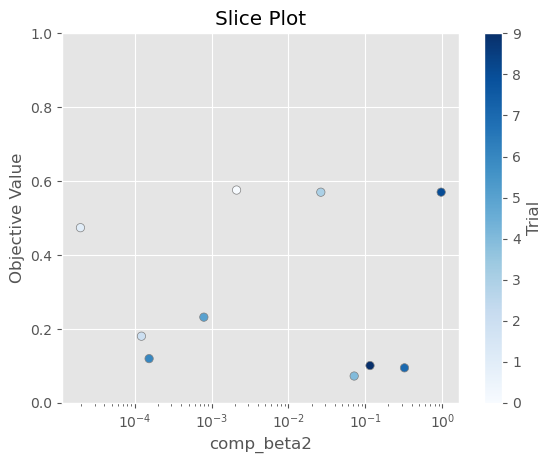

In [32]:
for param in study.best_params.keys():
    ax = optuna.visualization.matplotlib.plot_slice(study, params=[param])
    ax.set_ylim(0, 1)
    plt.show()

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\4290272586.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_contour(study)
[W 2022-09-27 20:48:15,175] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


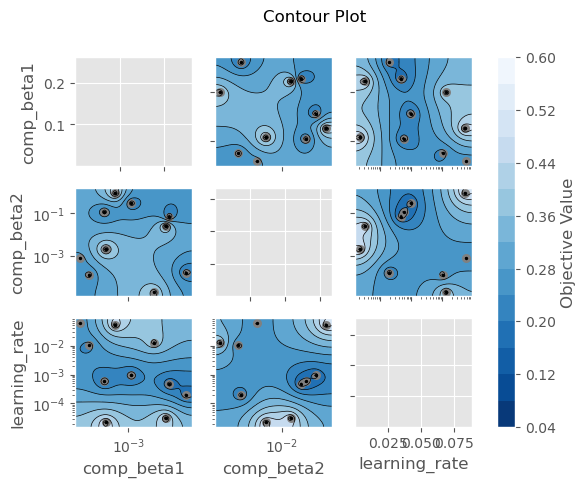

In [33]:
ax = optuna.visualization.matplotlib.plot_contour(study)
plt.show()

In [34]:
study.optimize(objective, n_trials=90, n_jobs=4)

[I 2022-09-27 20:48:21,214] Trial 10 finished with value: 0.21185477077960968 and parameters: {'learning_rate': 0.249829432334246, 'comp_beta1': 0.5608511468660351, 'comp_beta2': 0.025737973786644858}. Best is trial 4 with value: 0.07276993989944458.
[I 2022-09-27 20:48:21,264] Trial 12 finished with value: 0.1237257570028305 and parameters: {'learning_rate': 0.22483117312333303, 'comp_beta1': 0.8550034704861682, 'comp_beta2': 0.021392176252192405}. Best is trial 4 with value: 0.07276993989944458.
[I 2022-09-27 20:48:21,439] Trial 11 finished with value: 0.18900173902511597 and parameters: {'learning_rate': 0.4926710249758174, 'comp_beta1': 0.7683444617882452, 'comp_beta2': 0.020928254208880188}. Best is trial 4 with value: 0.07276993989944458.
[I 2022-09-27 20:48:21,483] Trial 13 finished with value: 0.22284412384033203 and parameters: {'learning_rate': 0.30794784570556144, 'comp_beta1': 0.5440880216443932, 'comp_beta2': 0.010053276378413356}. Best is trial 4 with value: 0.07276993989

[I 2022-09-27 20:48:51,809] Trial 41 finished with value: 0.7848368287086487 and parameters: {'learning_rate': 0.05220352474045693, 'comp_beta1': 5.46883248286801e-05, 'comp_beta2': 0.0013468318858423638}. Best is trial 39 with value: 0.05766800045967102.
[I 2022-09-27 20:48:54,157] Trial 42 finished with value: 5.961846351623535 and parameters: {'learning_rate': 0.02432617066151285, 'comp_beta1': 0.05706397384492924, 'comp_beta2': 0.0009350507893883641}. Best is trial 39 with value: 0.05766800045967102.
[I 2022-09-27 20:48:54,736] Trial 43 finished with value: 0.3489862382411957 and parameters: {'learning_rate': 0.037650441895421154, 'comp_beta1': 0.03908475728197159, 'comp_beta2': 1.8748763070916202e-05}. Best is trial 39 with value: 0.05766800045967102.
[I 2022-09-27 20:48:55,219] Trial 44 finished with value: 0.17873866856098175 and parameters: {'learning_rate': 0.004696220336096159, 'comp_beta1': 0.01970800448776802, 'comp_beta2': 1.694808483079921e-05}. Best is trial 39 with valu

[I 2022-09-27 20:49:25,146] Trial 72 finished with value: 0.0656023770570755 and parameters: {'learning_rate': 0.003651065631285597, 'comp_beta1': 6.0919067291367984e-05, 'comp_beta2': 0.12411444634465989}. Best is trial 47 with value: 0.04845041781663895.
[I 2022-09-27 20:49:26,329] Trial 73 finished with value: 0.20468762516975403 and parameters: {'learning_rate': 0.014568125685819291, 'comp_beta1': 8.332950621721822e-05, 'comp_beta2': 0.012895883304487443}. Best is trial 47 with value: 0.04845041781663895.
[I 2022-09-27 20:49:27,164] Trial 74 finished with value: 0.107795849442482 and parameters: {'learning_rate': 0.004124583576233407, 'comp_beta1': 0.0014150868654822452, 'comp_beta2': 0.16601320380940263}. Best is trial 47 with value: 0.04845041781663895.
[I 2022-09-27 20:49:28,372] Trial 75 finished with value: 0.10213806480169296 and parameters: {'learning_rate': 0.0036360391545420872, 'comp_beta1': 0.006713397146264898, 'comp_beta2': 0.4732960776924674}. Best is trial 47 with va

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\580515141.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_slice(study, params=[param])


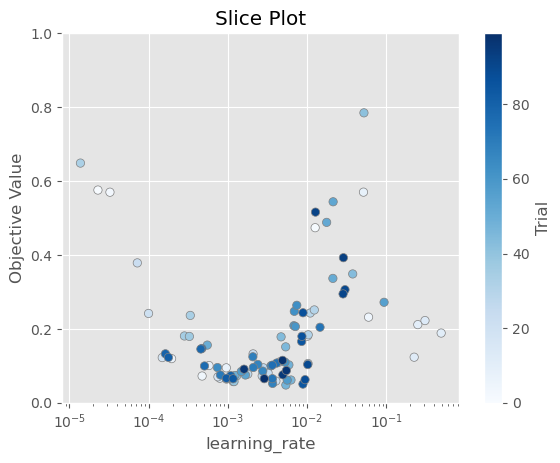

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\580515141.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_slice(study, params=[param])


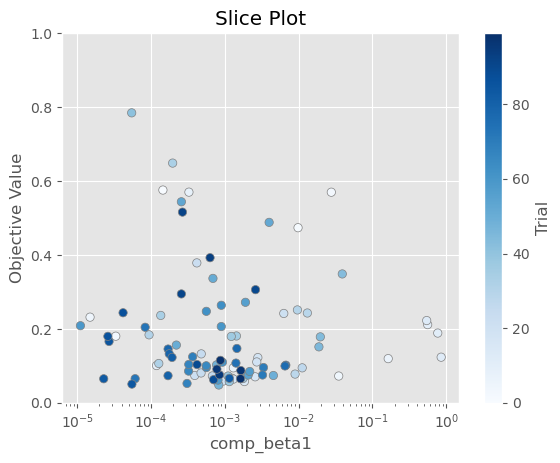

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\580515141.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_slice(study, params=[param])


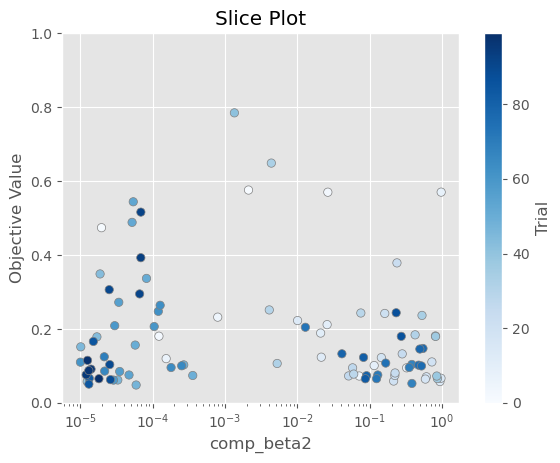

In [35]:
for param in study.best_params.keys():
    ax = optuna.visualization.matplotlib.plot_slice(study, params=[param])
    ax.set_ylim(0, 1)
    plt.show()

C:\Users\Sakishita\AppData\Local\Temp\ipykernel_6168\1479670383.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_contour(study, target=lambda trial:min(0.5, trial.value))
[W 2022-09-27 20:57:00,797] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
C:\Users\Sakishita\anaconda3\envs\torch\lib\site-packages\optuna\visualization\_utils.py:69: UserWarning: `target` is specified, but `target_name` is the default value, 'Objective Value'.
  warnings.warn(


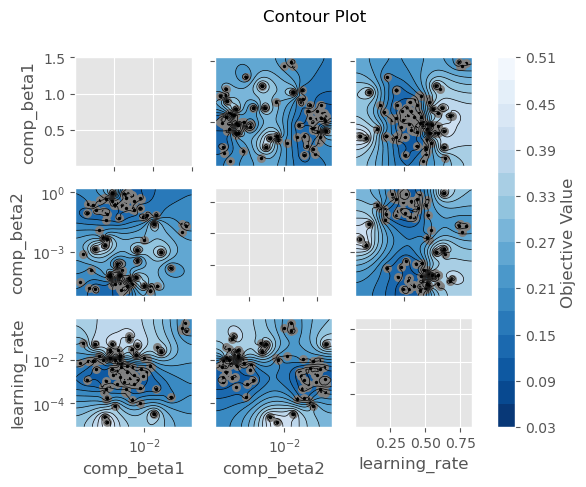

In [37]:
ax = optuna.visualization.matplotlib.plot_contour(study, target=lambda trial:min(0.5, trial.value))
plt.show()